In [1]:
import csv
import math
import random
import pandas as pd

In [2]:
# Brick and wall constants (in meters)
BRICK_L = 0.2
BRICK_W = 0.1
BRICK_H = 0.1
NUM_BRICKS = 10000
T = 0.2  # wall thickness

TOTAL_VOLUME = BRICK_L * BRICK_W * BRICK_H * NUM_BRICKS

In [3]:
def used_volume(L, W, H):
    """Volume of 6 walls (closed cuboid)"""
    return 2 * (L * W * T + L * H * T + W * H * T)

def internal_volume(L, W, H):
    """Internal hollow volume"""
    L_in = L - 2 * T
    W_in = W - 2 * T
    H_in = H - 2 * T
    if L_in <= 0 or W_in <= 0 or H_in <= 0:
        return -1
    return L_in * W_in * H_in


In [4]:
# ---------- Step 1: Finding optimal cuboid ----------
best_dims = (0, 0, 0)
max_Vin = 0
for L in [i * BRICK_L for i in range(20, 200)]:  # search 4m – 40m
    for W in [i * BRICK_L for i in range(20, 200)]:
        for H in [i * BRICK_H for i in range(20, 200)]:
            V_used = used_volume(L, W, H)
            if abs(V_used - TOTAL_VOLUME) < 0.5:  # brick match
                Vin = internal_volume(L, W, H)
                if Vin > max_Vin:
                    max_Vin = Vin
                    best_dims = (L, W, H)

L, W, H = best_dims
print("Best outer dimensions:", best_dims)
print("Inner dimensions:", (L - 2*T, W - 2*T, H - 2*T))
print("Max inner volume:", max_Vin)

Best outer dimensions: (4.0, 4.2, 4.2)
Inner dimensions: (3.6, 3.8000000000000003, 3.8000000000000003)
Max inner volume: 51.98400000000001


In [5]:
# ---------- Step 2: Placeing bricks ----------
bricks = []
brick_id = 1

# Floor
z = 0
for x in [i * BRICK_L for i in range(int(L / BRICK_L))]:
    for y in [i * BRICK_W for i in range(int(W / BRICK_W))]:
        bricks.append((brick_id, x, y, z, "Floor (X-orient)"))
        brick_id += 1

# Roof
z = H - BRICK_H
for x in [i * BRICK_L for i in range(int(L / BRICK_L))]:
    for y in [i * BRICK_W for i in range(int(W / BRICK_W))]:
        bricks.append((brick_id, x, y, z, "Roof (X-orient)"))
        brick_id += 1

# Walls
for k in range(1, int(H / BRICK_H) - 1):  # exclude floor & roof layers
    z = k * BRICK_H

    # X=0 wall
    for y in [i * BRICK_W for i in range(int(W / BRICK_W))]:
        bricks.append((brick_id, 0, y, z, "Wall (Z-orient)"))
        brick_id += 1

    # X=L-T wall
    for y in [i * BRICK_W for i in range(int(W / BRICK_W))]:
        bricks.append((brick_id, L - T, y, z, "Wall (Z-orient)"))
        brick_id += 1

    # Y=0 wall
    for x in [i * BRICK_L for i in range(int(L / BRICK_L))]:
        bricks.append((brick_id, x, 0, z, "Wall (Z-orient)"))
        brick_id += 1

    # Y=W-T wall
    for x in [i * BRICK_L for i in range(int(L / BRICK_L))]:
        bricks.append((brick_id, x, W - T, z, "Wall (Z-orient)"))
        brick_id += 1

In [6]:
# ---------- Step 3: Saveing to CSV ----------
csv_filename = "brick_layout.csv"
with open(csv_filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["BrickID", "X", "Y", "Z", "Orientation"])
    writer.writerows(bricks)

print(f"Brick placement plan saved to '{csv_filename}'.")

Brick placement plan saved to 'brick_layout.csv'.


In [7]:
# ---------- Step 4: Showing random 50 records ----------
df = pd.read_csv(csv_filename)
print("\nRandom 50 brick placements:\n")
print(df.sample(50))


Random 50 brick placements:

      BrickID    X    Y    Z       Orientation
5350     5351  3.8  3.2  3.0   Wall (Z-orient)
3296     3297  0.0  0.4  1.4   Wall (Z-orient)
4092     4093  3.8  1.4  2.0   Wall (Z-orient)
4563     4564  0.0  3.1  2.4   Wall (Z-orient)
142       143  0.6  1.6  0.0  Floor (X-orient)
3667     3668  0.0  0.3  1.7   Wall (Z-orient)
1512     1513  3.2  0.0  4.1   Roof (X-orient)
1515     1516  3.2  0.3  4.1   Roof (X-orient)
4499     4500  1.4  0.0  2.3   Wall (Z-orient)
1530     1531  3.2  1.8  4.1   Roof (X-orient)
1192     1193  1.6  1.6  4.1   Roof (X-orient)
107       108  0.4  2.3  0.0  Floor (X-orient)
6391     6392  3.8  4.0  3.8   Wall (Z-orient)
6236     6237  1.6  0.0  3.7   Wall (Z-orient)
4821     4822  0.0  4.1  2.6   Wall (Z-orient)
1005     1006  0.6  3.9  4.1   Roof (X-orient)
675       676  3.2  0.3  0.0  Floor (X-orient)
3472     3473  3.8  1.4  1.5   Wall (Z-orient)
5247     5248  2.2  0.0  2.9   Wall (Z-orient)
1021     1022  0.8  1.3  4.1  

In [8]:
import csv
import random
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

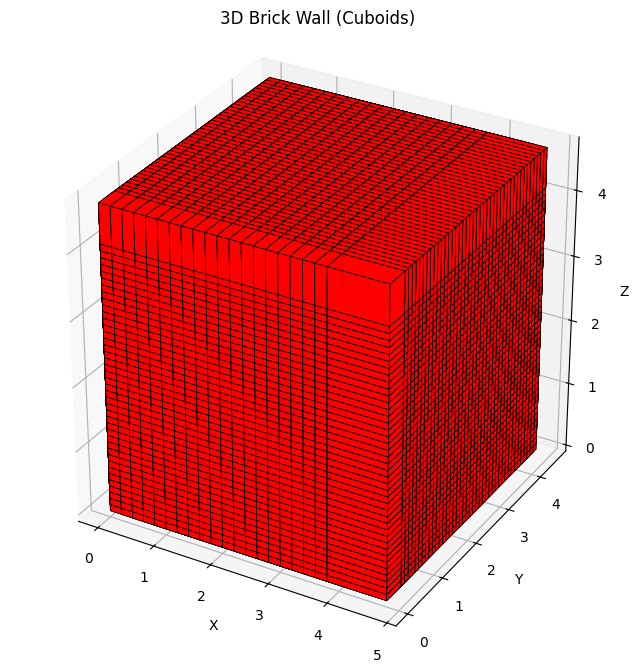

In [14]:
# Load your saved CSV
df = pd.read_csv("brick_layout.csv")

# Brick dimensions (LxWxH)
brick_length = 1.0   # X direction
brick_width  = 0.4   # Y direction
brick_height = 0.6   # Z direction

# Function to create vertices of a cuboid given its bottom corner
def cuboid_data(x, y, z, dx, dy, dz):
    return [
        # bottom face
        [(x, y, z), (x+dx, y, z), (x+dx, y+dy, z), (x, y+dy, z)],
        # top face
        [(x, y, z+dz), (x+dx, y, z+dz), (x+dx, y+dy, z+dz), (x, y+dy, z+dz)],
        # front face
        [(x, y, z), (x+dx, y, z), (x+dx, y, z+dz), (x, y, z+dz)],
        # back face
        [(x, y+dy, z), (x+dx, y+dy, z), (x+dx, y+dy, z+dz), (x, y+dy, z+dz)],
        # left face
        [(x, y, z), (x, y+dy, z), (x, y+dy, z+dz), (x, y, z+dz)],
        # right face
        [(x+dx, y, z), (x+dx, y+dy, z), (x+dx, y+dy, z+dz), (x+dx, y, z+dz)]
    ]

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw every brick
for _, row in df.iterrows():
    x, y, z = row["X"], row["Y"], row["Z"]

    # Adjust orientation 
    faces = cuboid_data(x, y, z, brick_length, brick_width, brick_height)

    # Create 3D collection
    ax.add_collection3d(Poly3DCollection(faces, facecolors='red', edgecolors='black', linewidths=0.5, alpha=0.9))

# Axis scaling
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_box_aspect([1,1,1])  # Aspect ratio

plt.title("3D Brick Wall (Cuboids)")
plt.show()

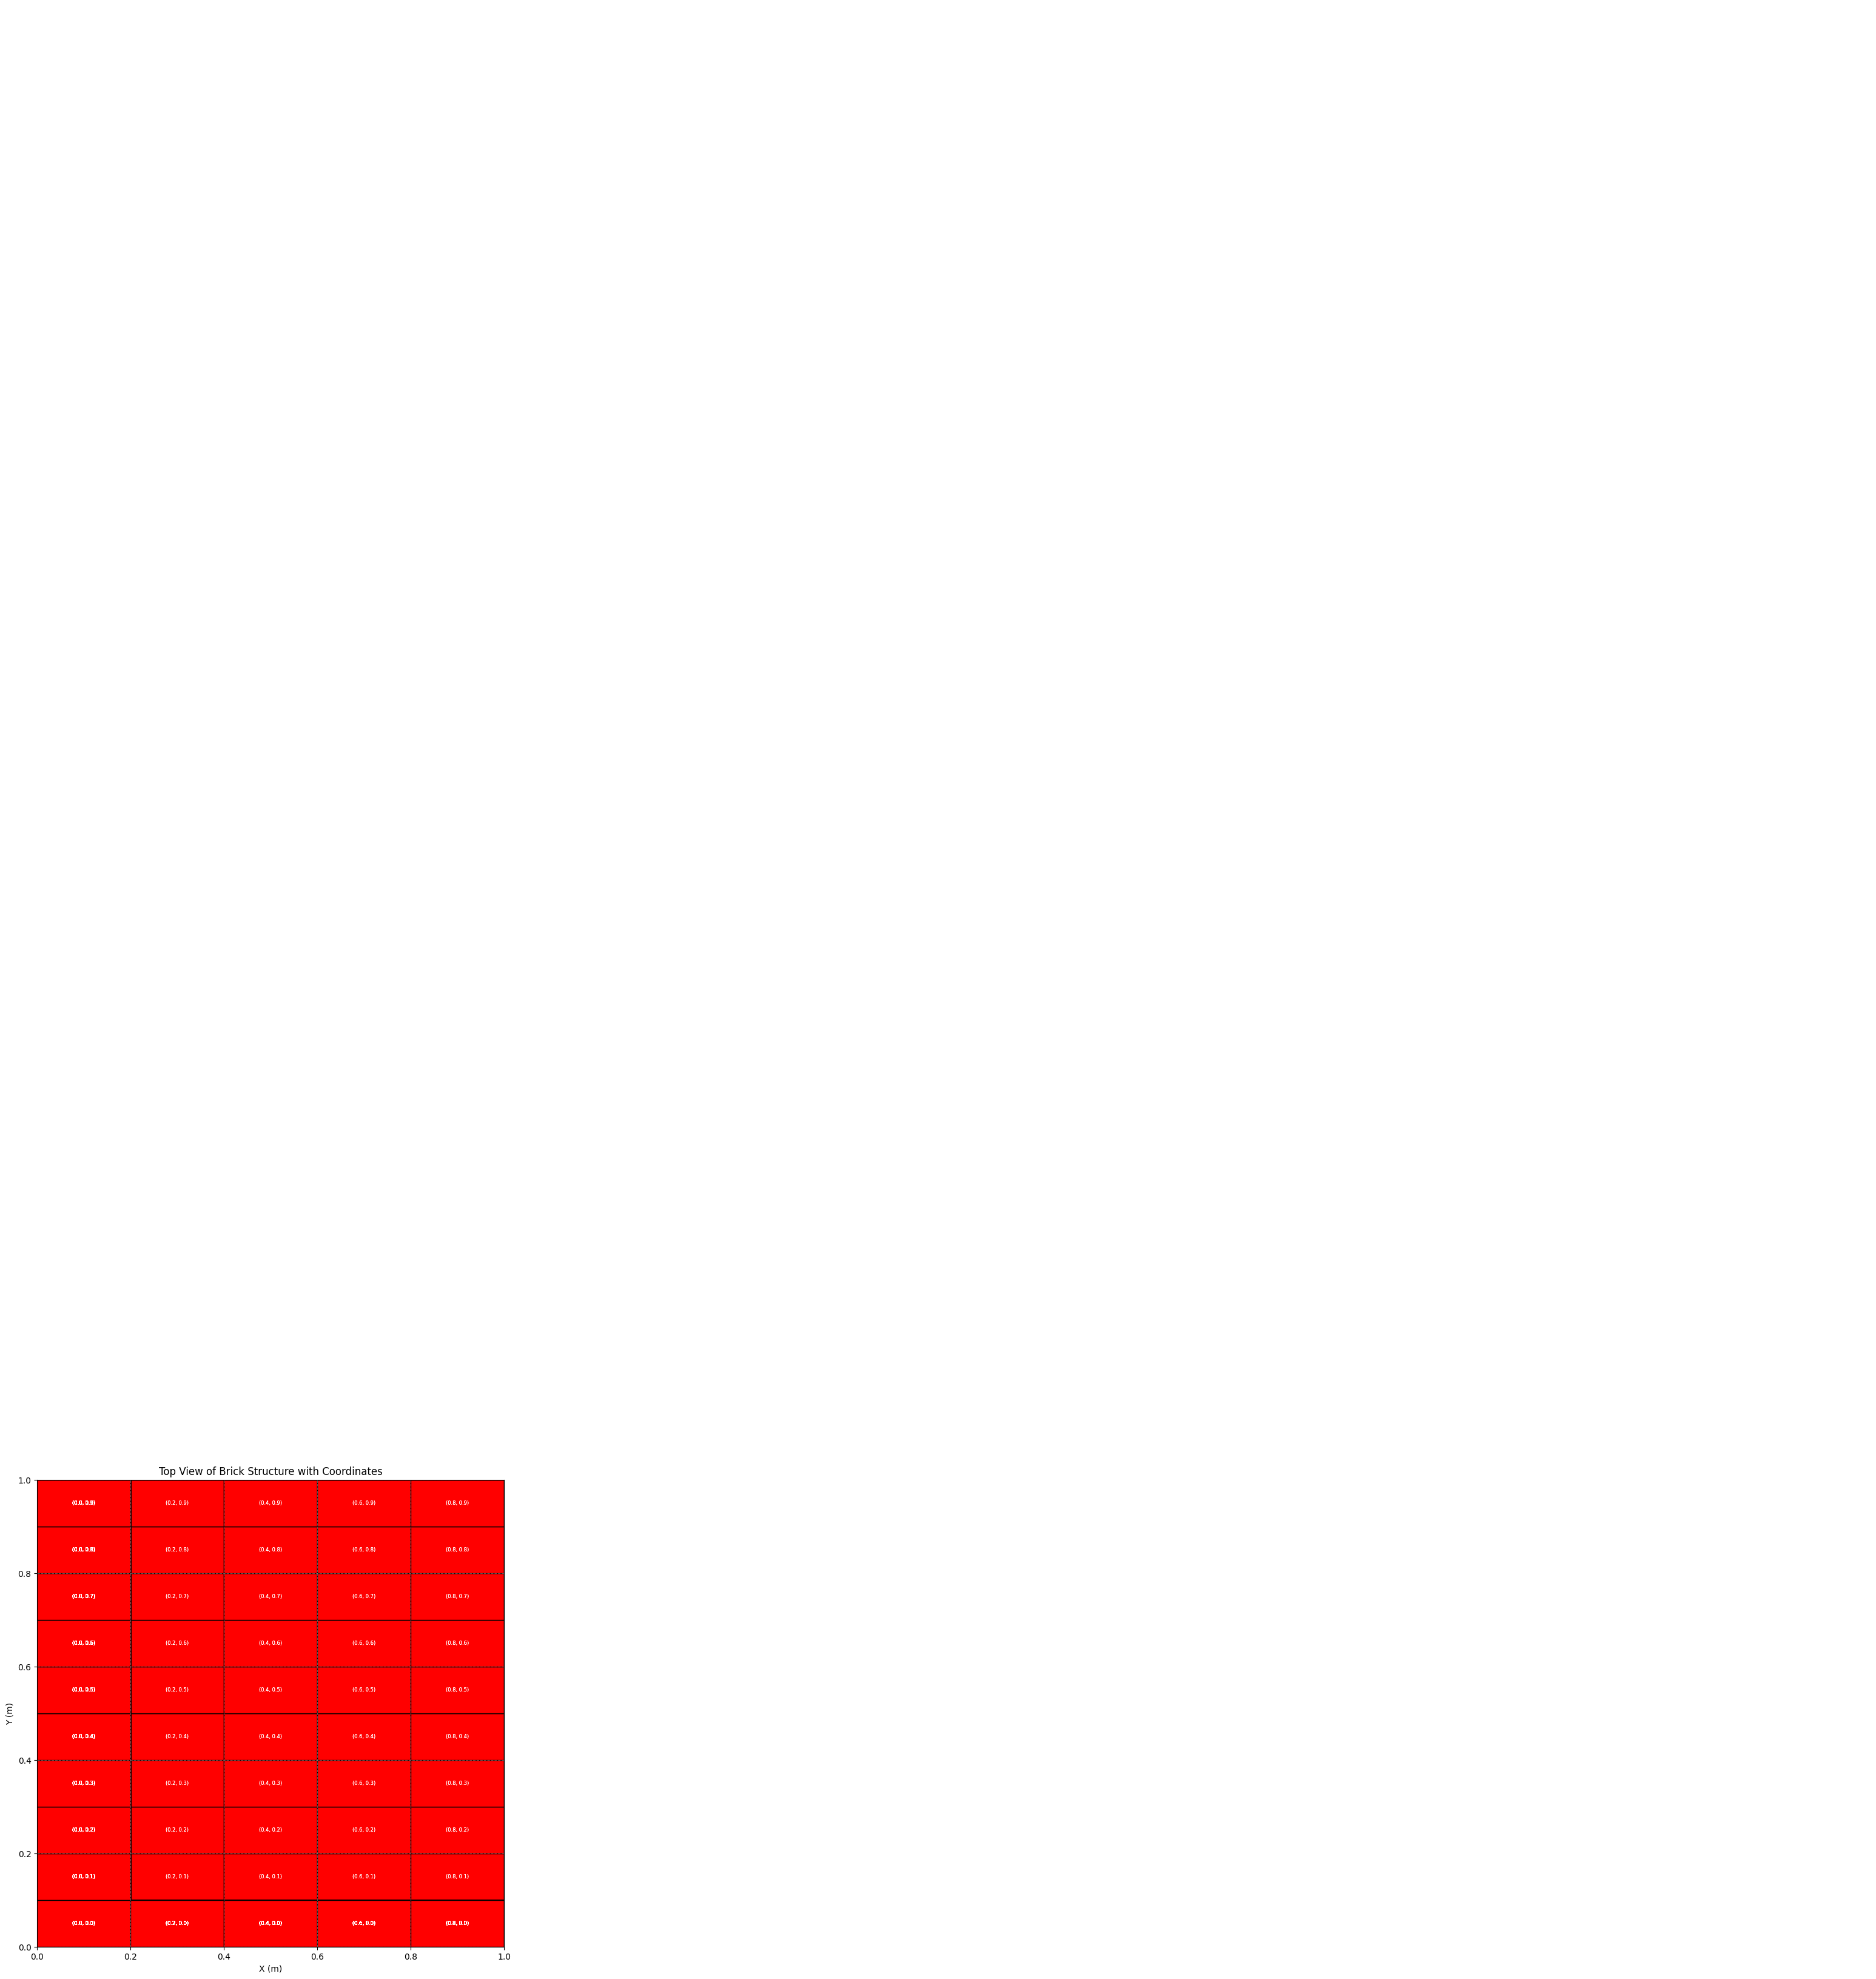

In [16]:
# Brick dimensions (must match your real ones)
BRICK_L, BRICK_W = 0.2, 0.1   # length (x), width (y) in meters

# Create top-view plot
fig, ax = plt.subplots(figsize=(10, 10))

for _, row in df.iterrows():
    x, y = row["X"], row["Y"]

    # Draw brick as a red rectangle with black border
    rect = plt.Rectangle((x, y), BRICK_L, BRICK_W,
                         facecolor="red", edgecolor="black", lw=1)
    ax.add_patch(rect)

    # Mark each brick with its (x, y) coordinate
    ax.text(x + BRICK_L/2, y + BRICK_W/2, 
            f"({x:.1f}, {y:.1f})", 
            ha="center", va="center", fontsize=6, color="white")

# Labels & scaling
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_title("Top View of Brick Structure with Coordinates")
ax.set_aspect("equal")  # equal scaling
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()